零基础入门金融风控-贷款违约预测<br>
比赛链接：https://tianchi.aliyun.com/competition/entrance/531830

# 导入库

In [47]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix,roc_auc_score ,roc_curve,auc
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder  
import xgboost
import lightgbm
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from boruta import BorutaPy
import datetime
from sklearn.model_selection import train_test_split


import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

In [2]:
import warnings
warnings.filterwarnings("ignore")

# 数据导入

In [3]:
data_train = pd.read_csv("train.csv")
data_test = pd.read_csv("testA.csv")
submit = pd.read_csv("sample_submit.csv")

# 数据分析与处理

In [4]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800000 entries, 0 to 799999
Data columns (total 47 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  800000 non-null  int64  
 1   loanAmnt            800000 non-null  float64
 2   term                800000 non-null  int64  
 3   interestRate        800000 non-null  float64
 4   installment         800000 non-null  float64
 5   grade               800000 non-null  object 
 6   subGrade            800000 non-null  object 
 7   employmentTitle     799999 non-null  float64
 8   employmentLength    753201 non-null  object 
 9   homeOwnership       800000 non-null  int64  
 10  annualIncome        800000 non-null  float64
 11  verificationStatus  800000 non-null  int64  
 12  issueDate           800000 non-null  object 
 13  isDefault           800000 non-null  int64  
 14  purpose             800000 non-null  int64  
 15  postCode            799999 non-nul

## 查看数值类型与对象类型特征

In [5]:
numerical_fea = list(data_train.select_dtypes(exclude=['object']).columns)
category_fea = list(filter(lambda x: x not in numerical_fea,list(data_train.columns)))

In [6]:
numerical_fea

['id',
 'loanAmnt',
 'term',
 'interestRate',
 'installment',
 'employmentTitle',
 'homeOwnership',
 'annualIncome',
 'verificationStatus',
 'isDefault',
 'purpose',
 'postCode',
 'regionCode',
 'dti',
 'delinquency_2years',
 'ficoRangeLow',
 'ficoRangeHigh',
 'openAcc',
 'pubRec',
 'pubRecBankruptcies',
 'revolBal',
 'revolUtil',
 'totalAcc',
 'initialListStatus',
 'applicationType',
 'title',
 'policyCode',
 'n0',
 'n1',
 'n2',
 'n3',
 'n4',
 'n5',
 'n6',
 'n7',
 'n8',
 'n9',
 'n10',
 'n11',
 'n12',
 'n13',
 'n14']

In [7]:
category_fea

['grade', 'subGrade', 'employmentLength', 'issueDate', 'earliesCreditLine']

## 数值型变量分析
分类出连续型变量和离散型变量

In [8]:
#过滤数值型类别特征
def get_numerical_serial_fea(data,feas):
    numerical_serial_fea = []
    numerical_noserial_fea = []
    for fea in feas:
        temp = data[fea].nunique()
        if temp <= 10:
            numerical_noserial_fea.append(fea)
            continue
        numerical_serial_fea.append(fea)
    return numerical_serial_fea,numerical_noserial_fea

numerical_serial_fea,numerical_noserial_fea = get_numerical_serial_fea(data_train,numerical_fea)

### 离散型变量分析

In [9]:
numerical_noserial_fea

['term',
 'homeOwnership',
 'verificationStatus',
 'isDefault',
 'initialListStatus',
 'applicationType',
 'policyCode',
 'n11',
 'n12']

In [10]:
print(data_train['term'].value_counts())
print()
print(data_train['homeOwnership'].value_counts())
print()
print(data_train['verificationStatus'].value_counts())
print()
print(data_train['initialListStatus'].value_counts())
print()
print(data_train['applicationType'].value_counts())
print()
print(data_train['policyCode'].value_counts())
print()
print(data_train['n11'].value_counts())
print()
print(data_train['n12'].value_counts())

term
3    606902
5    193098
Name: count, dtype: int64

homeOwnership
0    395732
1    317660
2     86309
3       185
5        81
4        33
Name: count, dtype: int64

verificationStatus
1    309810
2    248968
0    241222
Name: count, dtype: int64

initialListStatus
0    466438
1    333562
Name: count, dtype: int64

applicationType
0    784586
1     15414
Name: count, dtype: int64

policyCode
1.0    800000
Name: count, dtype: int64

n11
0.0    729682
1.0       540
2.0        24
4.0         1
3.0         1
Name: count, dtype: int64

n12
0.0    757315
1.0      2281
2.0       115
3.0        16
4.0         3
Name: count, dtype: int64


### 连续型变量分析

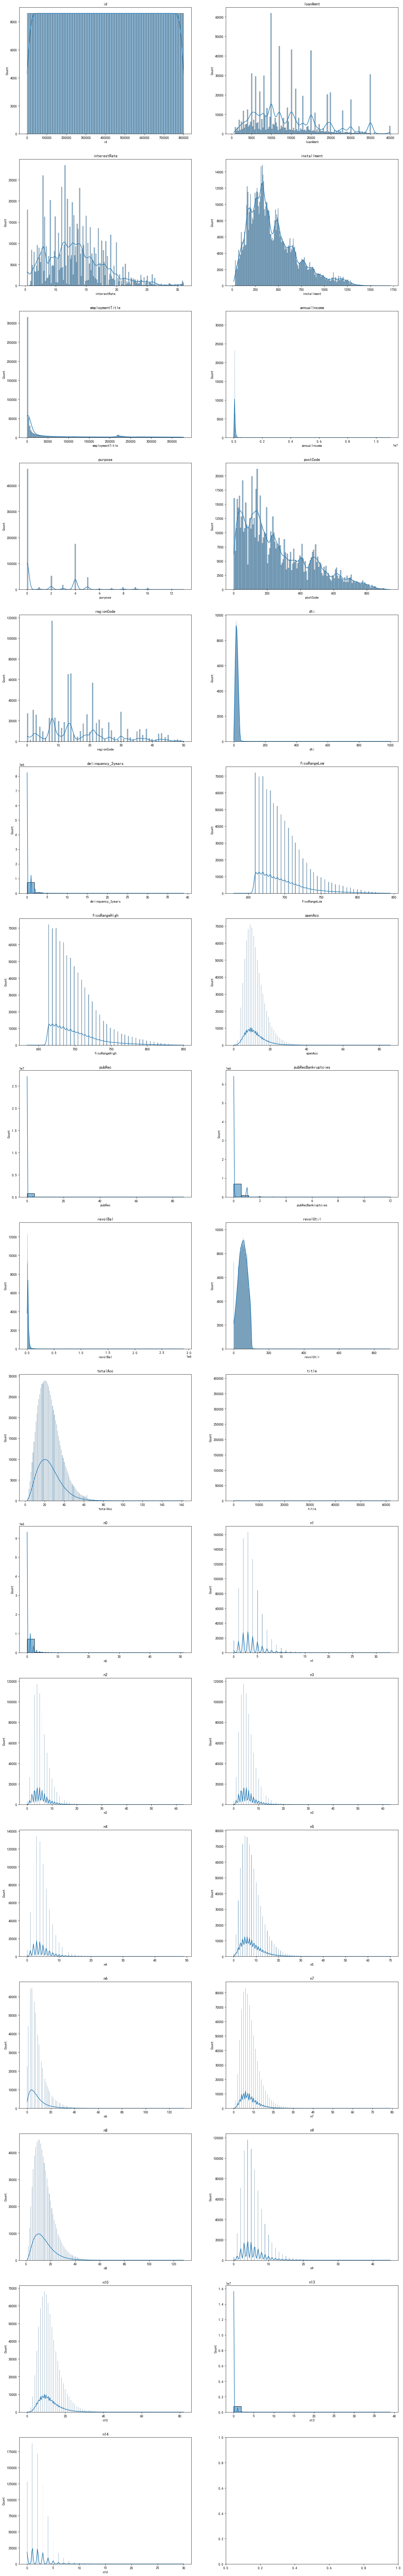

In [11]:
num_features = len(numerical_serial_fea)  
num_cols = 2  # 每行两个直方图  
num_rows = (num_features + num_cols - 1) // num_cols  # 向上取整计算行数  
  
# 创建足够的子图  
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(20, 8*num_rows))  # 调整宽度为20以适应两个直方图  
  
# 遍历每个特征并绘制直方图  
for i, feature in enumerate(numerical_serial_fea):  
    row = i // num_cols  # 计算当前特征应该在哪一行  
    col = i % num_cols   # 计算当前特征应该在哪一列  
    sns.histplot(data=data_train, x=feature, ax=axes[row, col], kde=True)  # 在正确的子图上绘图  
    axes[row, col].set_title(feature)  # 设置子图的标题为特征名称  


## 非数值类别型变量分析

In [12]:
category_fea

['grade', 'subGrade', 'employmentLength', 'issueDate', 'earliesCreditLine']

In [13]:
print(data_train['grade'].value_counts())
print()
print(data_train['subGrade'].value_counts())
print()
print(data_train['employmentLength'].value_counts())
print()
print(data_train['issueDate'].value_counts())
print()
print(data_train['earliesCreditLine'].value_counts())

grade
B    233690
C    227118
A    139661
D    119453
E     55661
F     19053
G      5364
Name: count, dtype: int64

subGrade
C1    50763
B4    49516
B5    48965
B3    48600
C2    47068
C3    44751
C4    44272
B2    44227
B1    42382
C5    40264
A5    38045
A4    30928
D1    30538
D2    26528
A1    25909
D3    23410
A3    22655
A2    22124
D4    21139
D5    17838
E1    14064
E2    12746
E3    10925
E4     9273
E5     8653
F1     5925
F2     4340
F3     3577
F4     2859
F5     2352
G1     1759
G2     1231
G3      978
G4      751
G5      645
Name: count, dtype: int64

employmentLength
10+ years    262753
2 years       72358
< 1 year      64237
3 years       64152
1 year        52489
5 years       50102
4 years       47985
6 years       37254
8 years       36192
7 years       35407
9 years       30272
Name: count, dtype: int64

issueDate
2016-03-01    29066
2015-10-01    25525
2015-07-01    24496
2015-12-01    23245
2014-10-01    21461
              ...  
2007-08-01       23
2007-07-01   

## 变量分布

### 类别型变量在不同y值上的分布

In [14]:
train_loan_fr = data_train.loc[data_train['isDefault'] == 1]
train_loan_nofr = data_train.loc[data_train['isDefault'] == 0]

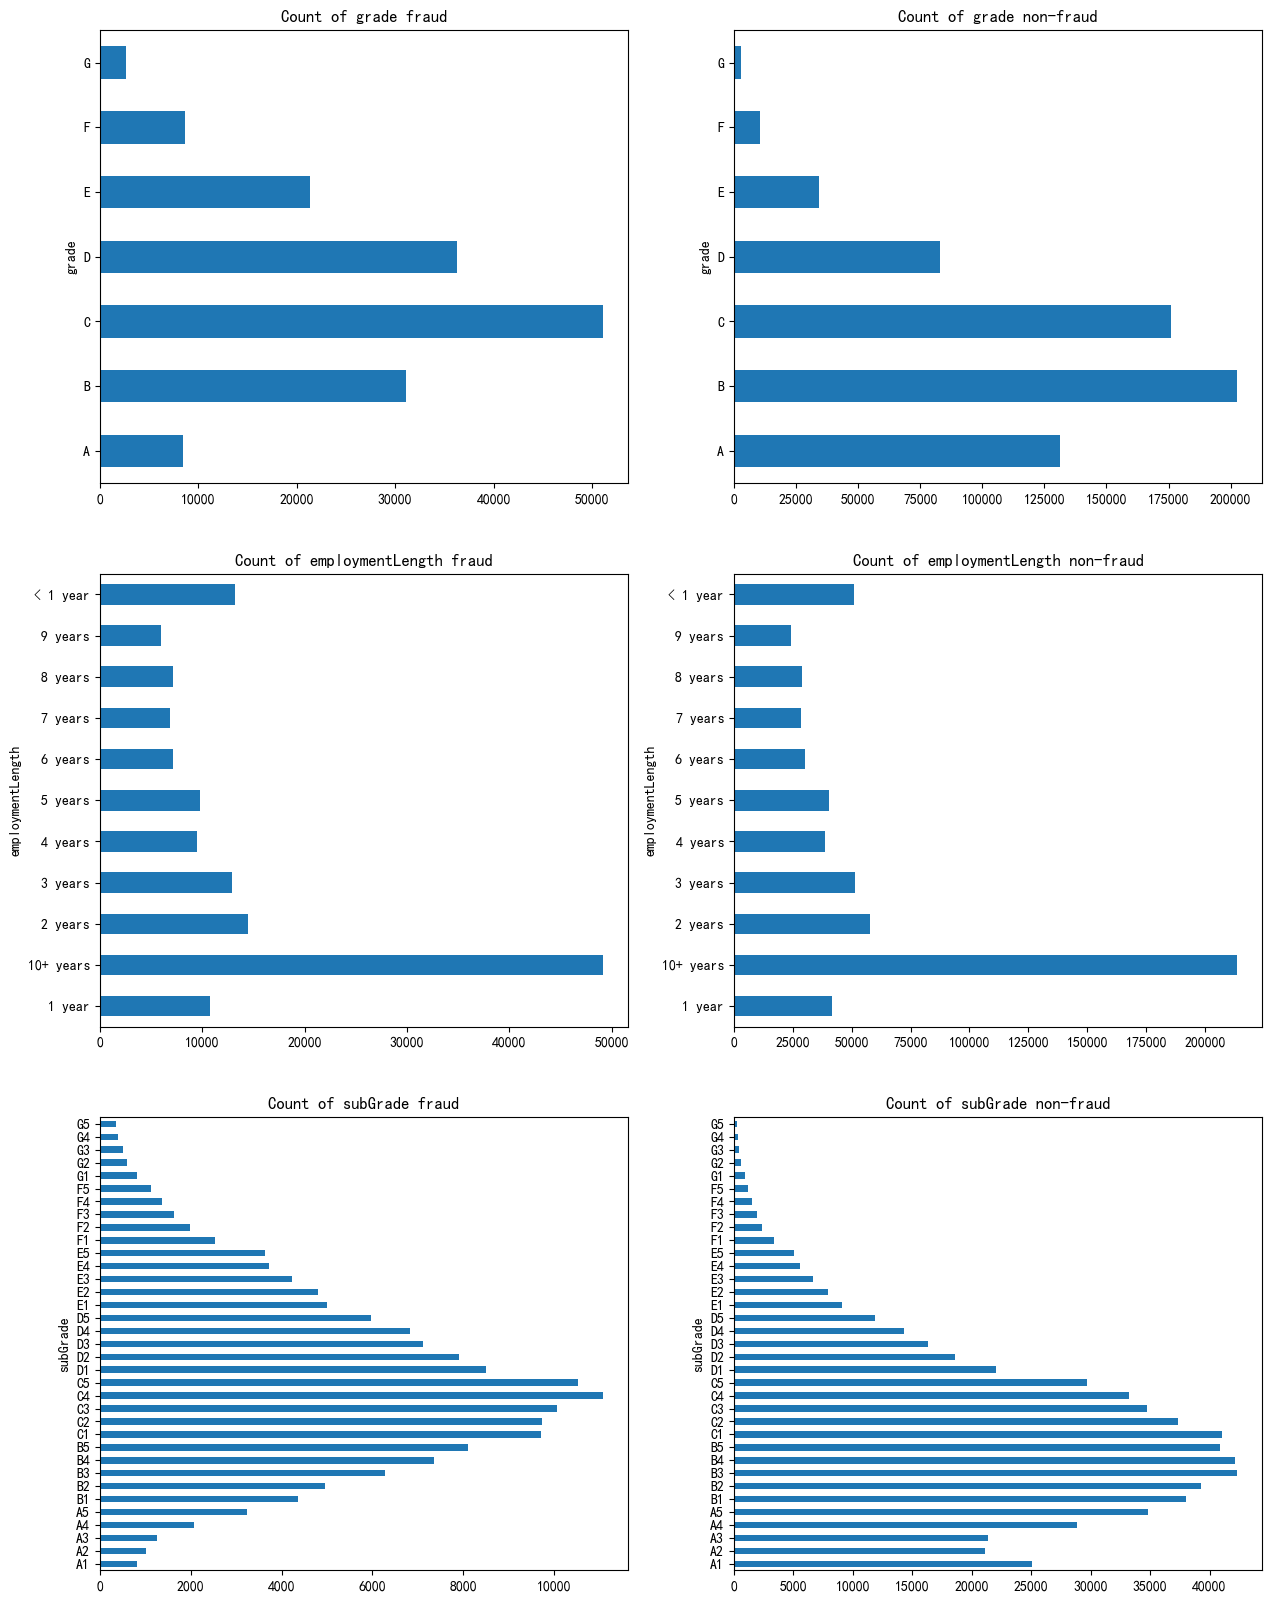

In [15]:
fig, ((ax1, ax2), (ax3, ax4),(ax5, ax6)) = plt.subplots(3, 2, figsize=(15, 20))
train_loan_fr.groupby('grade')['grade'].count().plot(kind='barh', ax=ax1, title='Count of grade fraud')
train_loan_nofr.groupby('grade')['grade'].count().plot(kind='barh', ax=ax2, title='Count of grade non-fraud')
train_loan_fr.groupby('employmentLength')['employmentLength'].count().plot(kind='barh', ax=ax3, title='Count of employmentLength fraud')
train_loan_nofr.groupby('employmentLength')['employmentLength'].count().plot(kind='barh', ax=ax4, title='Count of employmentLength non-fraud')
train_loan_fr.groupby('subGrade')['subGrade'].count().plot(kind='barh', ax=ax5, title='Count of subGrade fraud')
train_loan_nofr.groupby('subGrade')['subGrade'].count().plot(kind='barh', ax=ax6, title='Count of subGrade non-fraud')
plt.show()

### 连续型变量在不同y值上的分布

# 特征工程

In [16]:
label = 'isDefault'
numerical_fea.remove(label)

In [17]:
data_train.isnull().sum()

id                        0
loanAmnt                  0
term                      0
interestRate              0
installment               0
grade                     0
subGrade                  0
employmentTitle           1
employmentLength      46799
homeOwnership             0
annualIncome              0
verificationStatus        0
issueDate                 0
isDefault                 0
purpose                   0
postCode                  1
regionCode                0
dti                     239
delinquency_2years        0
ficoRangeLow              0
ficoRangeHigh             0
openAcc                   0
pubRec                    0
pubRecBankruptcies      405
revolBal                  0
revolUtil               531
totalAcc                  0
initialListStatus         0
applicationType           0
earliesCreditLine         0
title                     1
policyCode                0
n0                    40270
n1                    40270
n2                    40270
n3                  

In [18]:
#按照中位数填充数值型特征
data_train[numerical_fea] = data_train[numerical_fea].fillna(data_train[numerical_fea].median())
data_test[numerical_fea] = data_test[numerical_fea].fillna(data_train[numerical_fea].median())
#按照众数填充类别型特征
data_train[category_fea] = data_train[category_fea].fillna(data_train[category_fea].mode())
data_test[category_fea] = data_test[category_fea].fillna(data_train[category_fea].mode())

In [19]:
data_train.isnull().sum()

id                        0
loanAmnt                  0
term                      0
interestRate              0
installment               0
grade                     0
subGrade                  0
employmentTitle           0
employmentLength      46799
homeOwnership             0
annualIncome              0
verificationStatus        0
issueDate                 0
isDefault                 0
purpose                   0
postCode                  0
regionCode                0
dti                       0
delinquency_2years        0
ficoRangeLow              0
ficoRangeHigh             0
openAcc                   0
pubRec                    0
pubRecBankruptcies        0
revolBal                  0
revolUtil                 0
totalAcc                  0
initialListStatus         0
applicationType           0
earliesCreditLine         0
title                     0
policyCode                0
n0                        0
n1                        0
n2                        0
n3                  

In [20]:
# 查看类别特征
category_fea

['grade', 'subGrade', 'employmentLength', 'issueDate', 'earliesCreditLine']

## 时间格式处理

In [21]:
for data in [data_train, data_test]:
    data['issueDate'] = pd.to_datetime(data['issueDate'],format='%Y-%m-%d')
    startdate = datetime.datetime.strptime('2007-06-01', '%Y-%m-%d')
    #构造时间特征
    data['issueDateDT'] = data['issueDate'].apply(lambda x: x-startdate).dt.days

In [22]:
data_train['issueDateDT']

0         2587
1         1888
2         3044
3         2983
4         3196
          ... 
799995    3318
799996    2131
799997    3044
799998    2802
799999    4079
Name: issueDateDT, Length: 800000, dtype: int64

In [23]:
data_train['employmentLength'].value_counts(dropna=False).sort_index()

employmentLength
1 year        52489
10+ years    262753
2 years       72358
3 years       64152
4 years       47985
5 years       50102
6 years       37254
7 years       35407
8 years       36192
9 years       30272
< 1 year      64237
NaN           46799
Name: count, dtype: int64

## 对象类型特征转换到数值

In [24]:
def employmentLength_to_int(s):
    if pd.isnull(s):
        return s
    else:
        return np.int8(s.split()[0])
for data in [data_train, data_test]:
    data['employmentLength'].replace(to_replace='10+ years', value='10 years', inplace=True)
    data['employmentLength'].replace('< 1 year', '0 years', inplace=True)
    data['employmentLength'] = data['employmentLength'].apply(employmentLength_to_int)
    
data['employmentLength'].value_counts(dropna=False).sort_index()

employmentLength
0.0     15989
1.0     13182
2.0     18207
3.0     16011
4.0     11833
5.0     12543
6.0      9328
7.0      8823
8.0      8976
9.0      7594
10.0    65772
NaN     11742
Name: count, dtype: int64

对earliesCreditLine进行预处理

In [25]:
data_train['earliesCreditLine'].sample(5)

136711    Jul-2005
729540    Oct-2002
82492     Jan-2008
774062    Sep-1994
521759    Jun-2002
Name: earliesCreditLine, dtype: object

In [26]:
for data in [data_train, data_test]:
    data['earliesCreditLine'] = data['earliesCreditLine'].apply(lambda s: int(s[-4:]))
data['earliesCreditLine']

0         1974
1         2001
2         2006
3         2002
4         2000
          ... 
199995    2005
199996    2006
199997    2001
199998    2005
199999    2002
Name: earliesCreditLine, Length: 200000, dtype: int64

## 类别特征处理

In [27]:
# 像等级这种类别特征，是有优先级的可以labelencode或者自映射
for data in [data_train, data_test]:
    data['grade'] = data['grade'].map({'A':1,'B':2,'C':3,'D':4,'E':5,'F':6,'G':7})

In [28]:
# 类型数在2之上，又不是高维稀疏的,且纯分类特征
for data in [data_train, data_test]:
    data = pd.get_dummies(data, columns=['subGrade', 'homeOwnership', 'verificationStatus', 'purpose', 'regionCode'], drop_first=True)

In [29]:
#label-encode:subGrade,postCode,title
# 高维类别特征需要进行转换
for col in ['employmentTitle', 'postCode', 'title','subGrade']:
    le = LabelEncoder()
    le.fit(list(data_train[col].astype(str).values) + list(data_test[col].astype(str).values))
    data_train[col] = le.transform(list(data_train[col].astype(str).values))
    data_test[col] = le.transform(list(data_test[col].astype(str).values))
print('Label Encoding 完成')

Label Encoding 完成


## 特征选择

In [39]:
X_train = data_train.drop(['isDefault','issueDate'], axis=1)  
y_train = data_train['isDefault'] 

In [41]:
# XGB作为基模型的特征选择
selector = SelectFromModel(xgboost.XGBClassifier())

# 拟合选择器到训练数据  
selector.fit(X_train, y_train)
# 获取被选择的特征的索引（布尔数组转换为整数索引）  
selected_feature_indices = selector.get_support(indices=True)  
# 获取被选择的特征名称  
selected_feature_names = X_train.columns[selected_feature_indices]  
  
# 打印被选择的特征名称  
print("XGB Selected feature names:", selected_feature_names)

Selected feature names: Index(['term', 'grade', 'subGrade', 'homeOwnership'], dtype='object')


In [42]:
# LGB作为基模型的特征选择
selector = SelectFromModel(lightgbm.LGBMClassifier())

# 拟合选择器到训练数据  
selector.fit(X_train, y_train)
# 获取被选择的特征的索引（布尔数组转换为整数索引）  
selected_feature_indices = selector.get_support(indices=True)  
# 获取被选择的特征名称  
selected_feature_names = X_train.columns[selected_feature_indices]  
  
# 打印被选择的特征名称  
print("LGB Selected feature names:", selected_feature_names)

[LightGBM] [Info] Number of positive: 159610, number of negative: 640390
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032389 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4005
[LightGBM] [Info] Number of data points in the train set: 800000, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199513 -> initscore=-1.389344
[LightGBM] [Info] Start training from score -1.389344
LGB Selected feature names: Index(['loanAmnt', 'term', 'interestRate', 'installment', 'subGrade',
       'employmentLength', 'homeOwnership', 'annualIncome', 'regionCode',
       'dti', 'ficoRangeLow', 'revolBal', 'revolUtil', 'totalAcc',
       'earliesCreditLine', 'n2', 'n14', 'issueDateDT'],
      dtype='object')


[LightGBM] [Info] Number of positive: 127700, number of negative: 512300
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069009 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3992
[LightGBM] [Info] Number of data points in the train set: 640000, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199531 -> initscore=-1.389227
[LightGBM] [Info] Start training from score -1.389227
[LightGBM] [Info] Number of positive: 127700, number of negative: 512300
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004361 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1006
[LightGBM] [Info] Number of data points in the train set: 640000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199531 -> initscore=-1.389

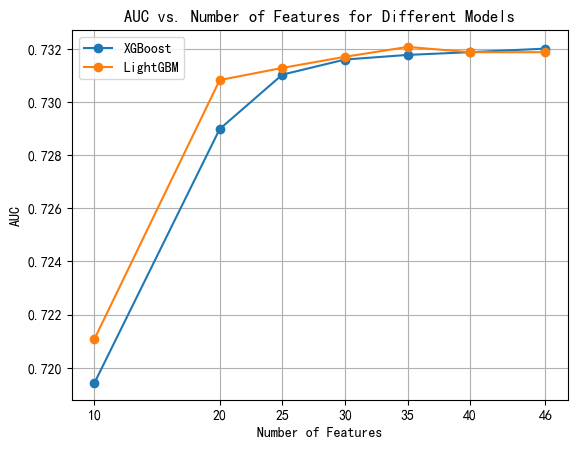

In [53]:
# 定义函数，用于训练模型并返回在验证集上的 AUC 和所选特征的索引列表
def train_and_evaluate(model, X_train, y_train, X_val, y_val, n_features):
    # 计算特征重要性
    model.fit(X_train, y_train)
    feature_importance = pd.Series(model.feature_importances_, index=X_train.columns).sort_values(ascending=False)# 从大到小排序
    
    # 选择重要性最高的 n 个特征
    selected_features = feature_importance[:n_features].index.tolist()
    X_train_selected = X_train[selected_features]
    X_val_selected = X_val[selected_features]
    
    # 训练模型
    model.fit(X_train_selected, y_train)
    
    # 在验证集上进行预测并计算 AUC
    y_pred = model.predict_proba(X_val_selected)[:, 1]
    auc1 = roc_auc_score(y_val, y_pred)
    
    return auc1, selected_features

train_X, test_X, train_y, test_y=train_test_split(X_train,y_train,test_size=0.2,random_state=12)

models = {
    'XGBoost': xgboost.XGBClassifier(importance_type = 'gain',random_state=12),
    'LightGBM': lightgbm.LGBMClassifier(importance_type = 'gain',random_state=12),
}
# 初始化列表存储 AUC 值和所选特征列表
auc_values_dict = {model_name: [] for model_name in models.keys()}
selected_features_dict = {model_name: [] for model_name in models.keys()}

n_values = [10, 20, 25, 30, 35, 40, 46]

# 遍历不同的模型
for model_name, model in models.items():
    # 遍历不同的特征数量
    for n in n_values:
        auc1, selected_features = train_and_evaluate(model, train_X, train_y, test_X, test_y, n)
        auc_values_dict[model_name].append(auc1)
        selected_features_dict[model_name].append(selected_features)
        
# 绘制折线图
for model_name, auc_values in auc_values_dict.items():
    plt.plot(n_values, auc_values, marker='o', label=model_name)
plt.xlabel('Number of Features')
plt.ylabel('AUC')
plt.title('AUC vs. Number of Features for Different Models')
plt.xticks(n_values)
plt.legend()
plt.grid(True)
plt.show()

In [54]:
# 查看前20个特征
xgboost_features = selected_features_dict['XGBoost']
value1 = xgboost_features[1]
print("XGB选择特征个数：{}\n特征：{}\n".format(len(value1),value1))

LightGBM_features = selected_features_dict['LightGBM']
value2 = LightGBM_features[1]
print("LGB选择特征个数：{}\n特征：{}\n".format(len(value2),value2))

XGB选择特征个数：20
特征：['grade', 'subGrade', 'term', 'homeOwnership', 'issueDateDT', 'n2', 'employmentLength', 'ficoRangeLow', 'loanAmnt', 'n14', 'dti', 'annualIncome', 'verificationStatus', 'applicationType', 'regionCode', 'revolBal', 'installment', 'n9', 'interestRate', 'pubRecBankruptcies']

LGB选择特征个数：20
特征：['subGrade', 'grade', 'issueDateDT', 'term', 'homeOwnership', 'dti', 'annualIncome', 'ficoRangeLow', 'employmentLength', 'revolBal', 'loanAmnt', 'n2', 'installment', 'regionCode', 'interestRate', 'n14', 'earliesCreditLine', 'revolUtil', 'n9', 'totalAcc']



# 模型建立

In [55]:
X_train = X_train[['subGrade', 'grade', 'issueDateDT', 'term', 'homeOwnership', 'dti', 'annualIncome', 'ficoRangeLow', 'employmentLength', 'revolBal', 'loanAmnt', 'n2', 'installment', 'regionCode', 'interestRate', 'n14', 'earliesCreditLine', 'revolUtil', 'n9', 'totalAcc']]
data_test = data_test[['subGrade', 'grade', 'issueDateDT', 'term', 'homeOwnership', 'dti', 'annualIncome', 'ficoRangeLow', 'employmentLength', 'revolBal', 'loanAmnt', 'n2', 'installment', 'regionCode', 'interestRate', 'n14', 'earliesCreditLine', 'revolUtil', 'n9', 'totalAcc']]

[LightGBM] [Info] Number of positive: 159610, number of negative: 640390
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005969 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2346
[LightGBM] [Info] Number of data points in the train set: 800000, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199513 -> initscore=-1.389344
[LightGBM] [Info] Start training from score -1.389344


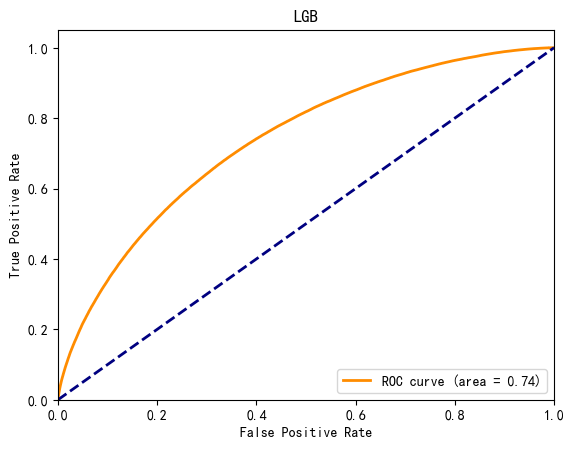

lgb AUC: 0.7367563328774697


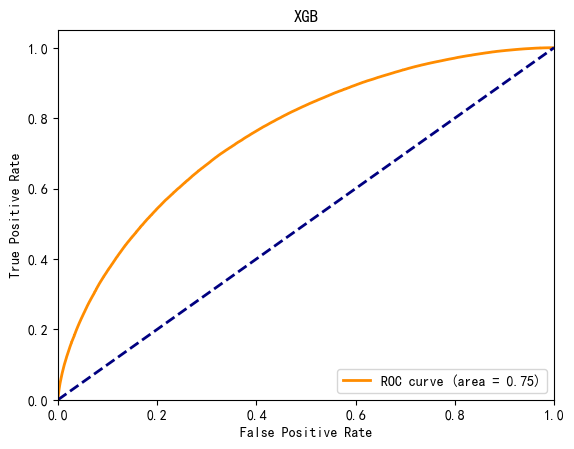

xgb AUC: 0.7534454578932791


In [62]:
lgb = lightgbm.LGBMClassifier(importance_type = 'gain',random_state=12)
lgb.fit(X_train, y_train)
test_probs = lgb.predict_proba(X_train)[:, 1]  
fpr, tpr, thresholds = roc_curve(y_train, test_probs)  
roc_auc = auc(fpr, tpr)  
# 绘制 ROC 曲线
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('LGB')
plt.legend(loc="lower right")
plt.show()
print("lgb AUC:",roc_auc)

xgb = xgboost.XGBClassifier(importance_type = 'gain',random_state=12)
xgb.fit(X_train, y_train)
test_probs = xgb.predict_proba(X_train)[:, 1]
fpr, tpr, thresholds = roc_curve(y_train, test_probs)  
roc_auc = auc(fpr, tpr)  
# 绘制 ROC 曲线
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGB')
plt.legend(loc="lower right")
plt.show()
print("xgb AUC:",roc_auc)

In [65]:
# 使用训练好的模型进行预测
predictions = xgb.predict(data_test)

# 创建包含 id 和预测结果的 DataFrame
results_df = pd.DataFrame({'id': data_test.index, 'isDefault': predictions})

# 将结果保存到 CSV 文件
results_df.to_csv('predictions.csv', index=False)

# 打印前几行结果
print(results_df.head())

   id  isDefault
0   0          0
1   1          0
2   2          1
3   3          0
4   4          0
